# Implementation 

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K


from tensorflow.keras.layers import Dense, Input, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.activations import softplus as f
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt
from keras.utils import Progbar

Using TensorFlow backend.


# Data

In [2]:
# the data, split between train and test sets
(x_train, _), _ = mnist.load_data()

In [3]:
# Reshape to (60K, 784) and (60K, 1)
x_train = x_train.reshape((60000, 784)) / 255.

In [4]:
# Shuffle
indices = np.arange(60000)
np.random.shuffle(indices)

In [5]:
def get_batch(i):
    return x_train[indices[i*BATCH_SIZE:i*BATCH_SIZE + BATCH_SIZE]]

## Utilites

In [6]:
normal = tf.initializers.RandomNormal

In [7]:
class DenseEQ(Dense):
    """
    Standard dense layer but includes learning rate equilization
    at runtime as per Karras et al. 2017.

    Inherits Dense layer and overides the call method.
    """
    def __init__(self, **kwargs):
        if 'kernel_initializer' in kwargs:
            raise Exception("Cannot override kernel_initializer")
        super().__init__(kernel_initializer=normal, **kwargs)

    def build(self, input_shape):
        super().build(input_shape)
        # The number of inputs
        n = np.product([int(val) for val in input_shape[1:]])
        # He initialisation constant
        self.c = np.sqrt(2/n)

    def call(self, inputs):
        output = K.dot(inputs, self.kernel*self.c) # scale kernel
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

# Models

In [8]:
X_DIM = np.product((28, 28, 1))
Z_DIM = 50
H_DIM = 1024
BATCH_SIZE = 128

### F Network

In [9]:
F_input = Input(shape=(Z_DIM,))
x = DenseEQ(units=Z_DIM)(F_input)
x = LeakyReLU(0.2)(x)
x = DenseEQ(units=Z_DIM)(x)
x = LeakyReLU(0.2)(x)
x = DenseEQ(units=Z_DIM)(x)
F_output = LeakyReLU(0.2)(x)
F = Model(inputs=[F_input],
          outputs=[F_output], name="F")

### D Network

In [10]:
D_input = Input(shape=(Z_DIM,))
x = DenseEQ(units=Z_DIM)(D_input)
x = LeakyReLU(0.2)(x)
x = DenseEQ(units=Z_DIM)(x)
x = LeakyReLU(0.2)(x)
D_output = DenseEQ(units=1)(x)
D = Model(inputs=[D_input],
          outputs=[D_output], name="D")

### G Network

In [11]:
G_input = Input(shape=(Z_DIM,))
x = DenseEQ(units=H_DIM)(G_input)
x = LeakyReLU(0.2)(x)
x = DenseEQ(units=H_DIM)(x)
x = LeakyReLU(0.2)(x)
x = DenseEQ(units=X_DIM)(x)
G_output = LeakyReLU(0.2)(x)
G = Model(inputs=[G_input],
          outputs=[G_output], name="G")

### E Network

In [12]:
E_input = Input(shape=(X_DIM,))
x = DenseEQ(units=H_DIM)(E_input)
x = LeakyReLU(0.2)(x)
x = DenseEQ(units=H_DIM)(x)
x = LeakyReLU(0.2)(x)
x = DenseEQ(units=Z_DIM)(x)
E_output = LeakyReLU(0.2)(x)
E = Model(inputs=[E_input],
          outputs=[E_output], name="E")

With the sub-networks defined, we can put them together to create the Discriminator,Generator and Reciprocal networks, as well as the inference network.

$$
G = \mathbb{G} \circ F \\
D = \mathbb{D} \circ E \\
R = E \circ \mathbb{G} \circ F \\
I = E \circ G
$$

### Discriminator

In [13]:
discriminator_in = Input(shape=(X_DIM,))
discriminator_out = D(E(discriminator_in))
discriminator = Model(inputs=[discriminator_in],
                     outputs=[discriminator_out],
                     name="discriminator"
                    )

### Generator

In [14]:
generator_in = Input(shape=(Z_DIM,))
generator_out = G(F(generator_in))
generator = Model(inputs=[generator_in],
                     outputs=[generator_out],
                     name="generator"
                    )

### Reciprocal

In [15]:
reciprocal_in = Input(shape=(Z_DIM,)) # W is input
reciprocal_out = E(G(reciprocal_in))
reciprocal = Model(inputs=[reciprocal_in],
                     outputs=[reciprocal_out],
                     name="reciprocal"
                    )

### Inference

In [16]:
inference_in = Input(shape=(X_DIM,), name="inference_input")
inference_out = G(E(inference_in))
inference = Model(inputs=[inference_in],
                     outputs=[inference_out],
                     name="inference"
                    )

# Losses

In [17]:
def l2(x_true, x_pred):
    """
    L2 for the reciprocal loss in latent space
    
    :param - x_true - groundtruth
    :param - x_pred - prediction
    """
    return K.mean((x_true - x_pred)**2)

def discriminator_logistic_non_saturating(result, real): 
    """
    Discriminator loss, where f = softplus.
    
    :param - result - discriminator result
    :param - real - bool indicating real or fake output
    """

    if real:
        loss = f(-result)
    else:
        loss = f(result)
  
    return K.mean(loss)


def generator_logistic_non_saturating(result):
    """
    generator loss, where f = softplus
    """
    loss = f(-result)
    return K.mean(loss)

# Optimizers

In [18]:
# Parameters
θ_F = F.trainable_weights
θ_G = G.trainable_weights
θ_E = E.trainable_weights
θ_D = D.trainable_weights

# Hyper-parameters
α = 0.002
β1 = 0.0
β2 = 0.99
ε = K.epsilon()
γ=0.1

# Optimizers
Adam_D = Adam(α, β1, β2, ε)
Adam_G = Adam(α, β1, β2, ε)
Adam_R = Adam(α, β1, β2, ε)

# Training

In [19]:
# test z
z_test = np.random.normal(0, 1, (12, Z_DIM))
# test x
x_test = x_train[0:12]

# x_test as image stack 
x_reals = [img.reshape(28,28) for img in x_test]
x_reals = np.hstack(x_reals)

Epoch: 1
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3863 - Loss_G: 0.6937 - Loss_R: 6.6719e-07 

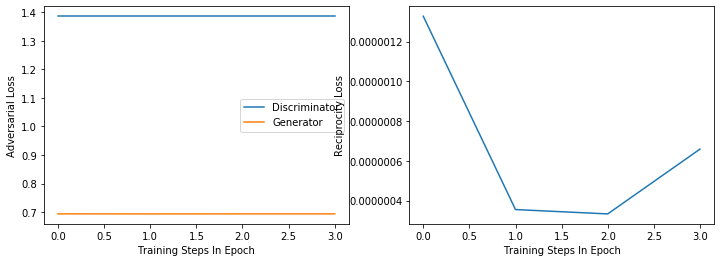

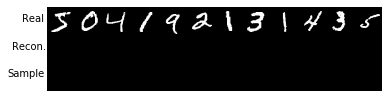

---------------------------------------------------------
Epoch: 2
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3850 - Loss_G: 0.7092 - Loss_R: 3.2289e-04 

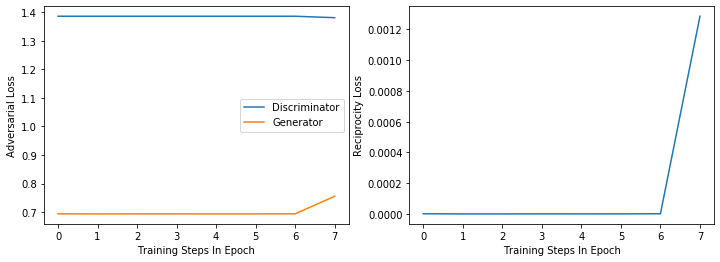

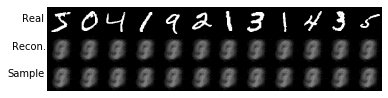

---------------------------------------------------------
Epoch: 3
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3006 - Loss_G: 0.7214 - Loss_R: 0.0050 

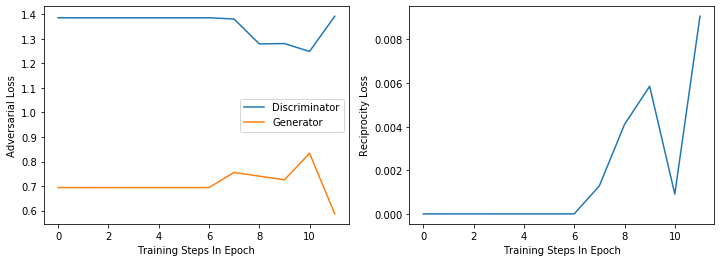

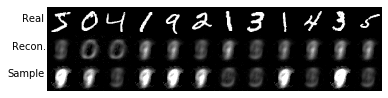

---------------------------------------------------------
Epoch: 4
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.2404 - Loss_G: 0.9187 - Loss_R: 0.0018 

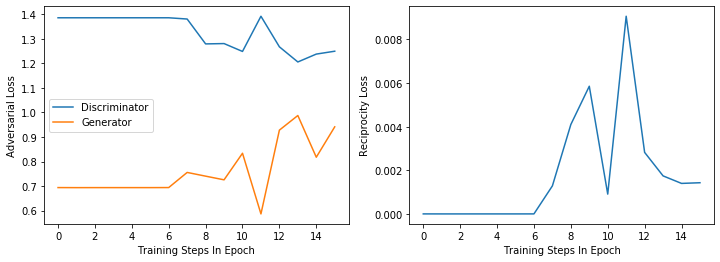

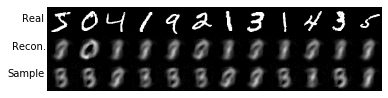

---------------------------------------------------------
Epoch: 5
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.2419 - Loss_G: 0.7720 - Loss_R: 0.0019 

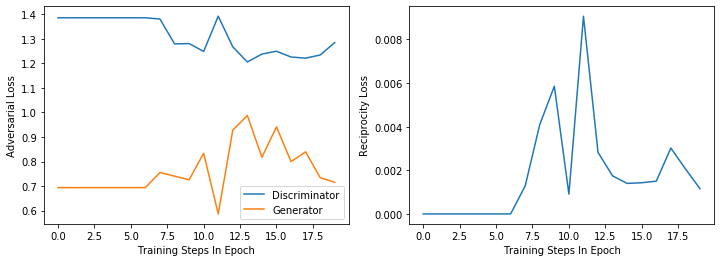

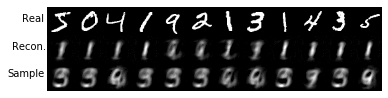

---------------------------------------------------------
Epoch: 6
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.2569 - Loss_G: 0.9142 - Loss_R: 0.0013 

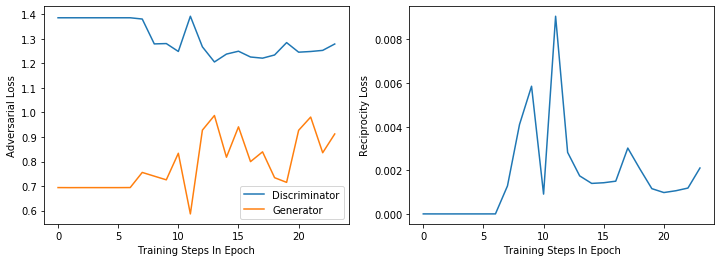

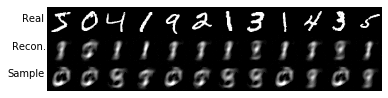

---------------------------------------------------------
Epoch: 7
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.2440 - Loss_G: 0.9445 - Loss_R: 0.0024 

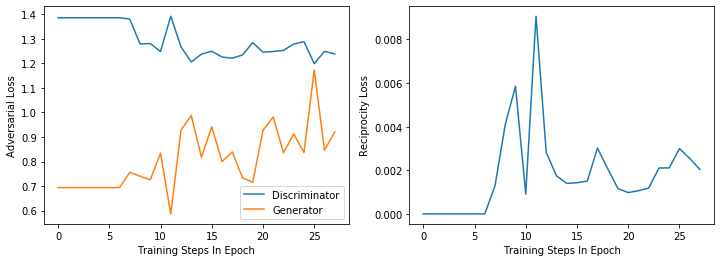

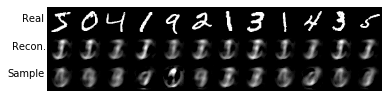

---------------------------------------------------------
Epoch: 8
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.2927 - Loss_G: 0.7997 - Loss_R: 0.0036 

---------------------------------------------------------
Epoch: 9
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3091 - Loss_G: 0.8237 - Loss_R: 0.0027 

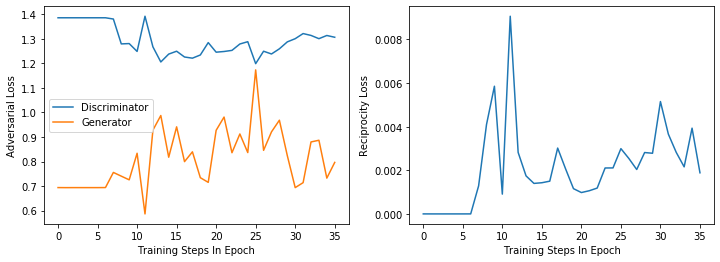

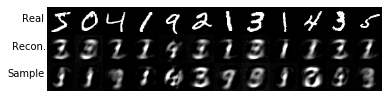

---------------------------------------------------------
Epoch: 10
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.2995 - Loss_G: 0.8021 - Loss_R: 0.0019 

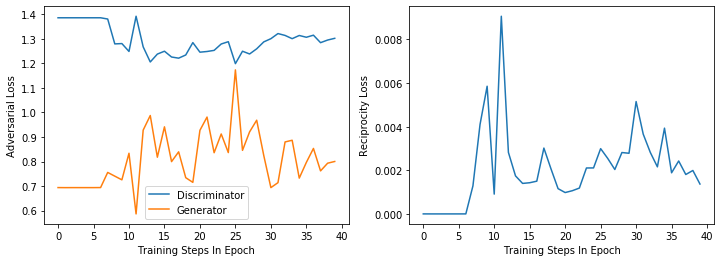

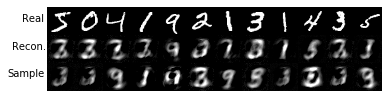

---------------------------------------------------------
Epoch: 11
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3069 - Loss_G: 0.8297 - Loss_R: 0.0035 

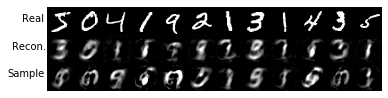

---------------------------------------------------------
Epoch: 12
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3156 - Loss_G: 0.8390 - Loss_R: 0.0064 

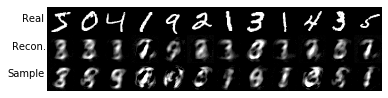

---------------------------------------------------------
Epoch: 13
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3265 - Loss_G: 0.7769 - Loss_R: 0.0070 

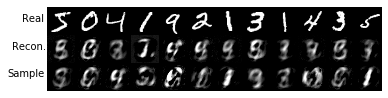

---------------------------------------------------------
Epoch: 14
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3442 - Loss_G: 0.6995 - Loss_R: 0.0149 

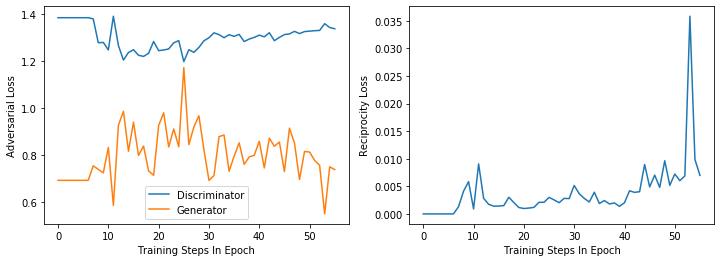

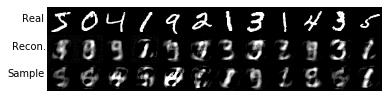

---------------------------------------------------------
Epoch: 15
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3431 - Loss_G: 0.7460 - Loss_R: 0.0092 

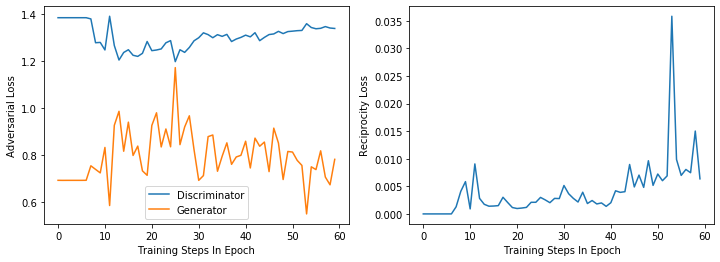

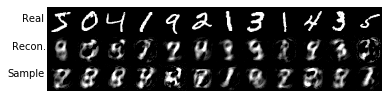

---------------------------------------------------------
Epoch: 16
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3497 - Loss_G: 0.7008 - Loss_R: 0.0098 

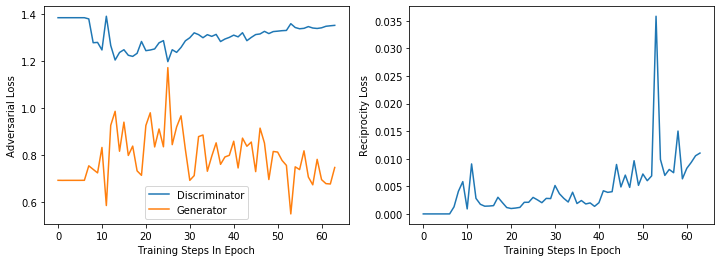

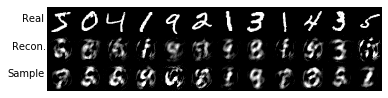

---------------------------------------------------------
Epoch: 17
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3593 - Loss_G: 0.7164 - Loss_R: 0.0138 

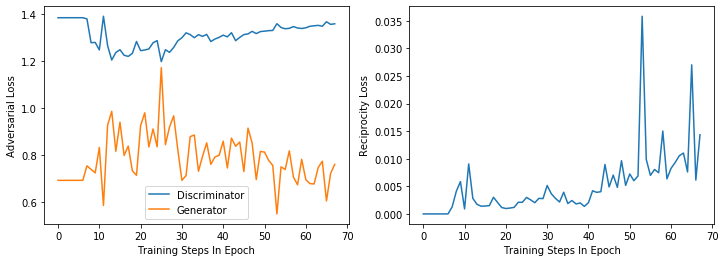

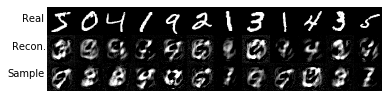

---------------------------------------------------------
Epoch: 18
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3630 - Loss_G: 0.7210 - Loss_R: 0.0113 

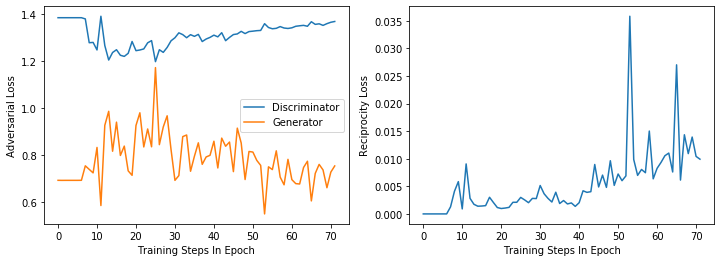

---------------------------------------------------------
Epoch: 19
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3621 - Loss_G: 0.7645 - Loss_R: 0.0181 

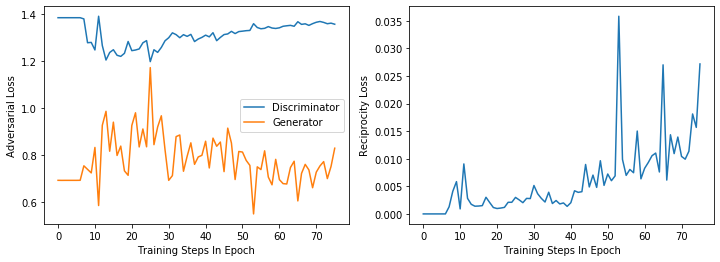

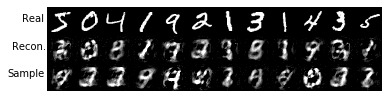

---------------------------------------------------------
Epoch: 20
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3652 - Loss_G: 0.7218 - Loss_R: 0.0194 

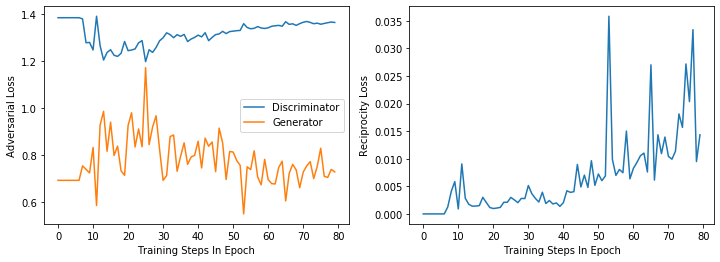

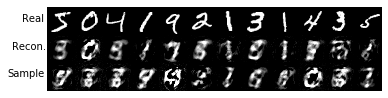

---------------------------------------------------------
Epoch: 21
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3627 - Loss_G: 0.7231 - Loss_R: 0.0165 

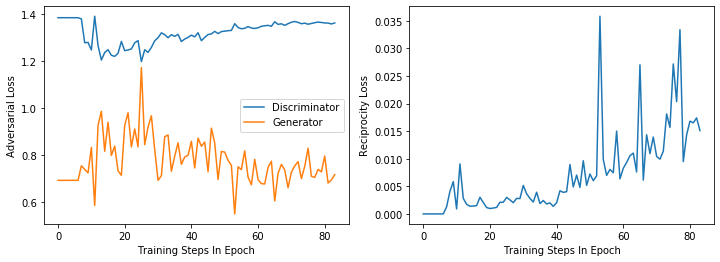

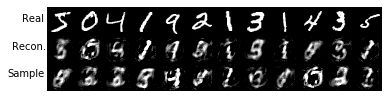

---------------------------------------------------------
Epoch: 22
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3694 - Loss_G: 0.7666 - Loss_R: 0.0323 

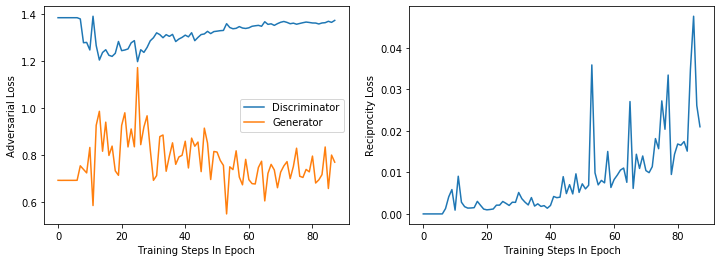

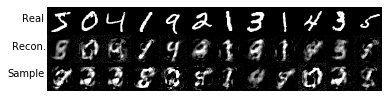

---------------------------------------------------------
Epoch: 23
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3699 - Loss_G: 0.6941 - Loss_R: 0.0427 

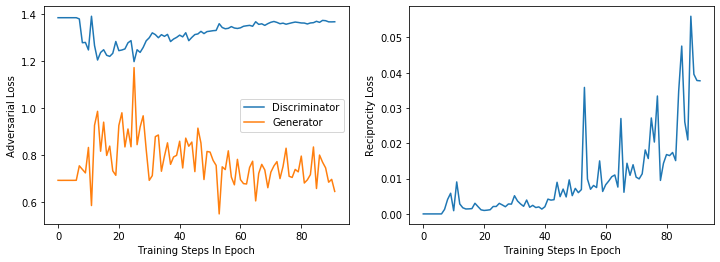

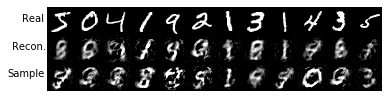

---------------------------------------------------------
Epoch: 24
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3729 - Loss_G: 0.7033 - Loss_R: 0.0489 

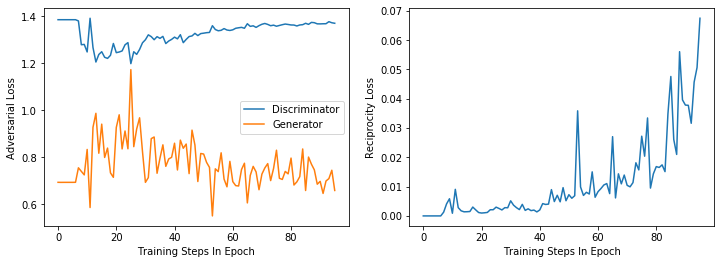

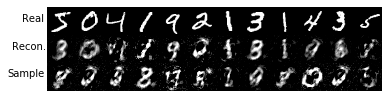

---------------------------------------------------------
Epoch: 25
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3722 - Loss_G: 0.7121 - Loss_R: 0.0464 

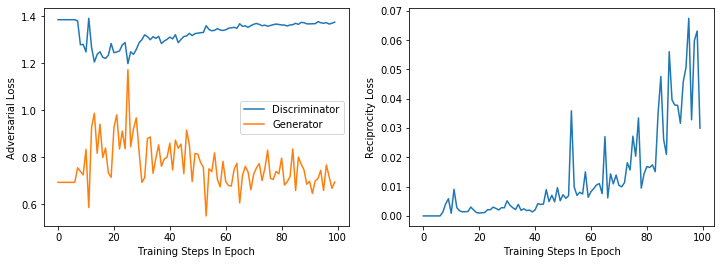

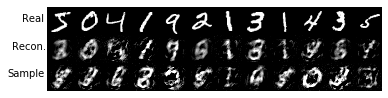

---------------------------------------------------------
Epoch: 26
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3768 - Loss_G: 0.6890 - Loss_R: 0.0690 

---------------------------------------------------------
Epoch: 27
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3746 - Loss_G: 0.7255 - Loss_R: 0.0812 

---------------------------------------------------------
Epoch: 28
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3777 - Loss_G: 0.6862 - Loss_R: 0.1742 

---------------------------------------------------------
Epoch: 29
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3799 - Loss_G: 0.7100 - Loss_R: 0.1541 

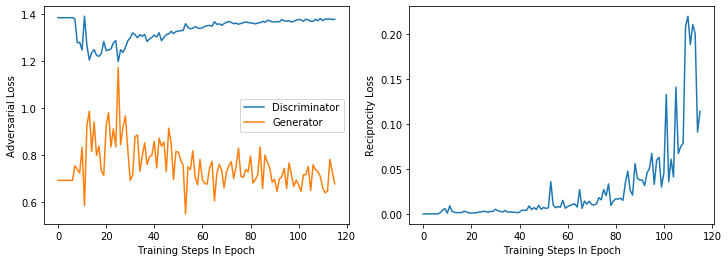

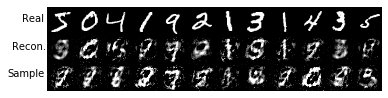

---------------------------------------------------------
Epoch: 30
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3788 - Loss_G: 0.6973 - Loss_R: 0.1291 

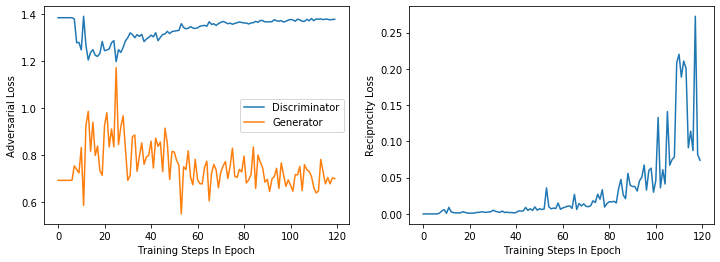

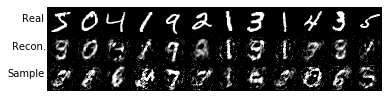

---------------------------------------------------------
Epoch: 31
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3796 - Loss_G: 0.7098 - Loss_R: 0.1068 

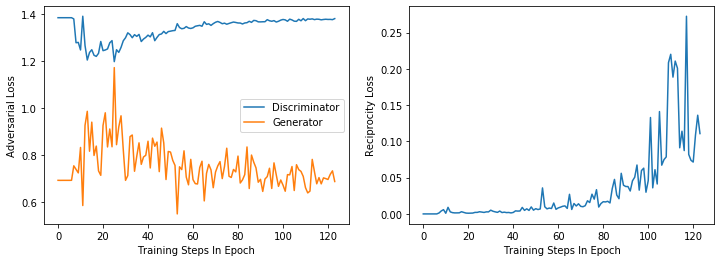

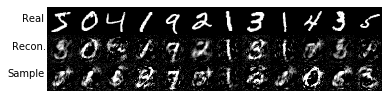

---------------------------------------------------------
Epoch: 32
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3802 - Loss_G: 0.7025 - Loss_R: 0.1973 

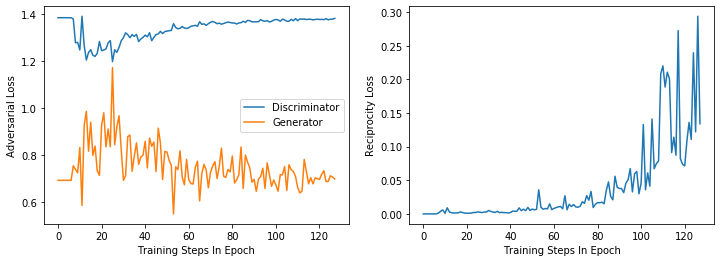

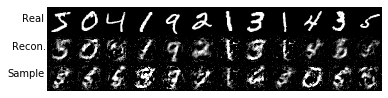

---------------------------------------------------------
Epoch: 33
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3810 - Loss_G: 0.7228 - Loss_R: 0.1610 

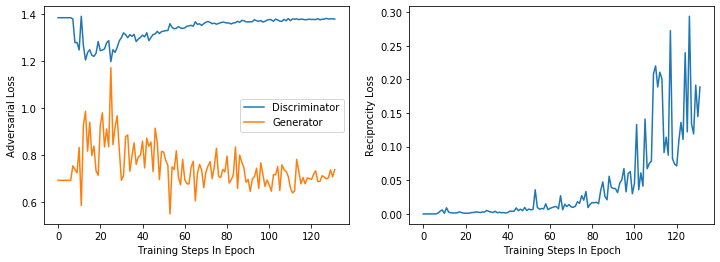

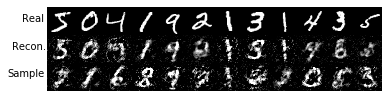

---------------------------------------------------------
Epoch: 34
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3806 - Loss_G: 0.7119 - Loss_R: 0.1588 

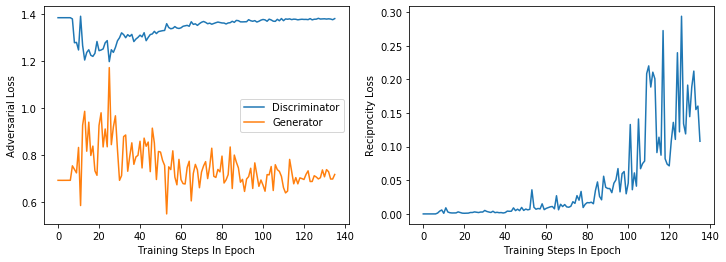

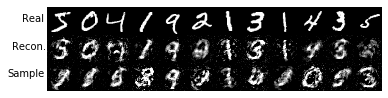

---------------------------------------------------------
Epoch: 35
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3796 - Loss_G: 0.7200 - Loss_R: 0.2054 

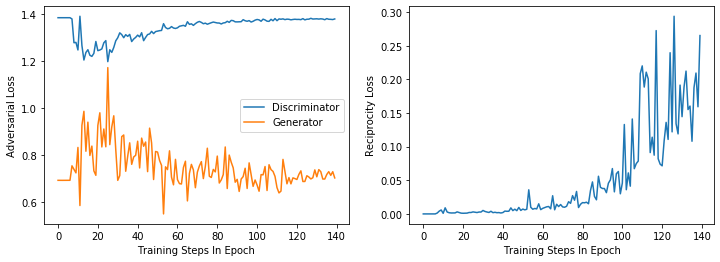

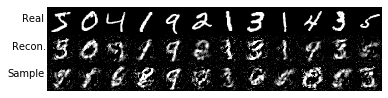

---------------------------------------------------------
Epoch: 36
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3809 - Loss_G: 0.7088 - Loss_R: 0.1775 

---------------------------------------------------------
Epoch: 37
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3820 - Loss_G: 0.7116 - Loss_R: 0.2197 

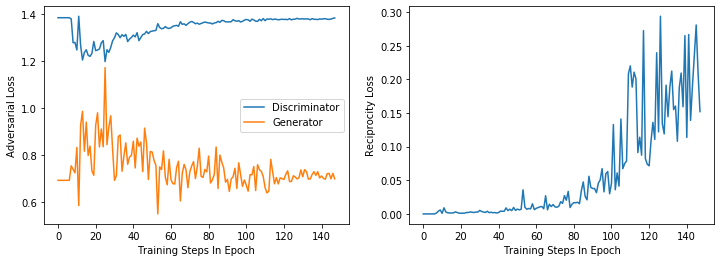

---------------------------------------------------------
Epoch: 38
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3803 - Loss_G: 0.7169 - Loss_R: 0.1905 

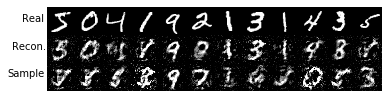

---------------------------------------------------------
Epoch: 39
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3813 - Loss_G: 0.7075 - Loss_R: 0.3030 

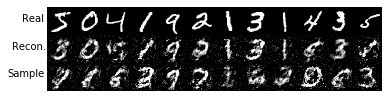

---------------------------------------------------------
Epoch: 40
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3825 - Loss_G: 0.6932 - Loss_R: 0.2771 

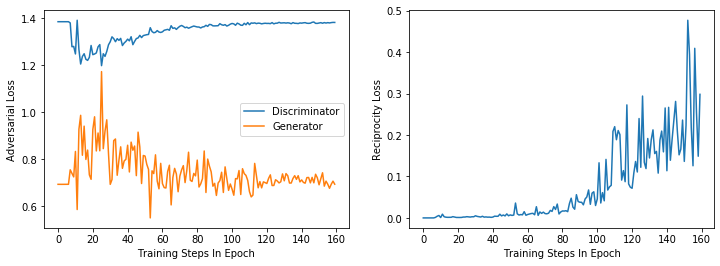

---------------------------------------------------------
Epoch: 41
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3824 - Loss_G: 0.6978 - Loss_R: 0.2506 

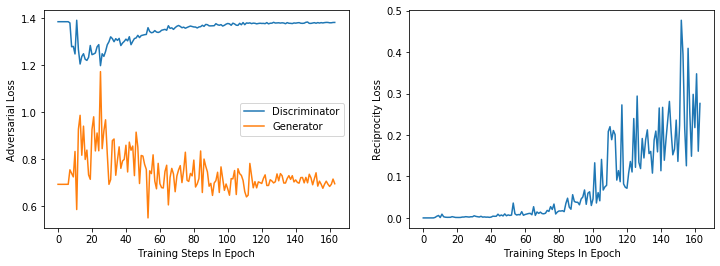

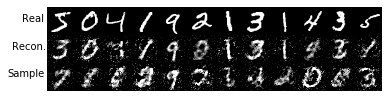

---------------------------------------------------------
Epoch: 42
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3830 - Loss_G: 0.7049 - Loss_R: 0.2965 

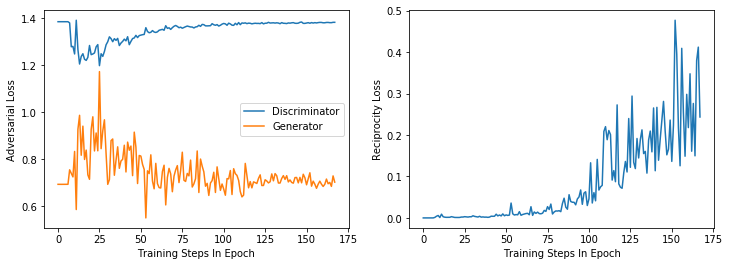

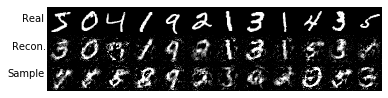

---------------------------------------------------------
Epoch: 43
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3813 - Loss_G: 0.7162 - Loss_R: 0.3948 

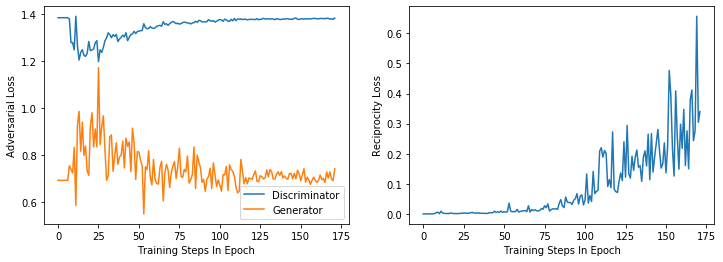

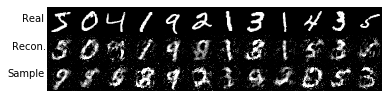

---------------------------------------------------------
Epoch: 44
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3824 - Loss_G: 0.7048 - Loss_R: 0.4068 

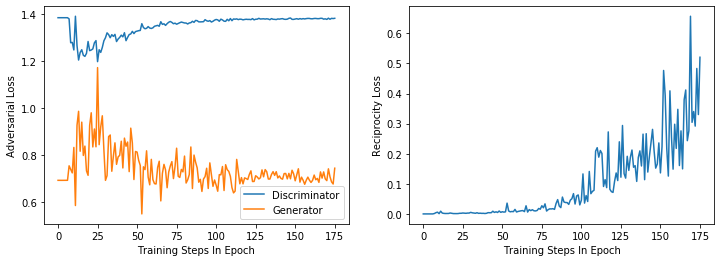

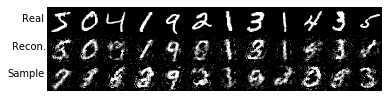

---------------------------------------------------------
Epoch: 45
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3811 - Loss_G: 0.7132 - Loss_R: 0.3241 

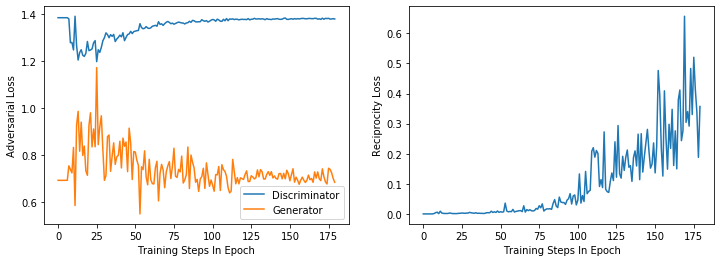

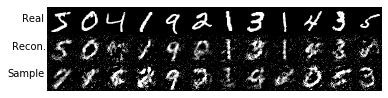

---------------------------------------------------------
Epoch: 46
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3813 - Loss_G: 0.7122 - Loss_R: 0.3327 

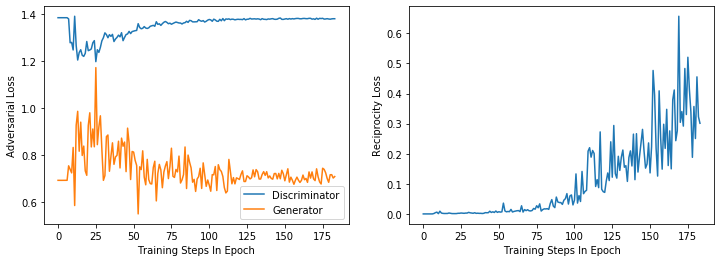

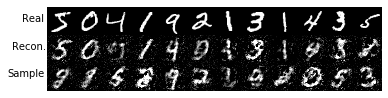

---------------------------------------------------------
Epoch: 47
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3822 - Loss_G: 0.6989 - Loss_R: 0.3218 

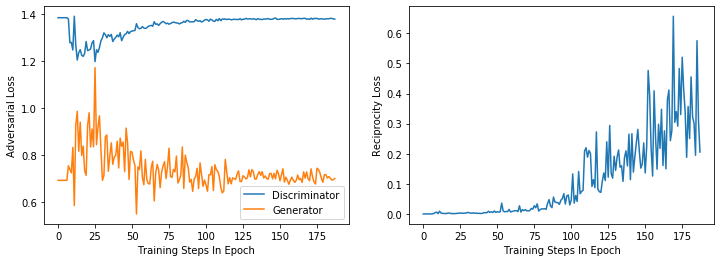

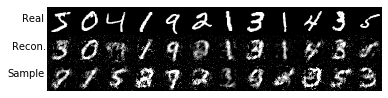

---------------------------------------------------------
Epoch: 48
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3824 - Loss_G: 0.6979 - Loss_R: 0.2695 

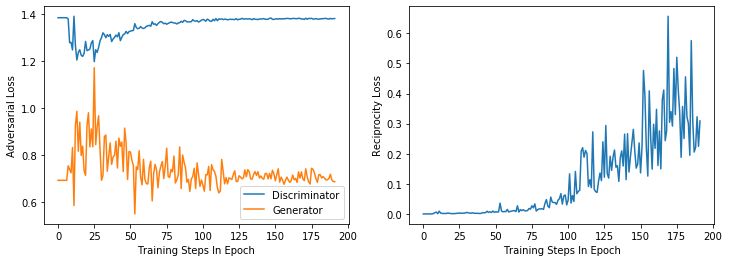

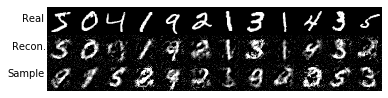

---------------------------------------------------------
Epoch: 49
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3826 - Loss_G: 0.7088 - Loss_R: 0.4605 

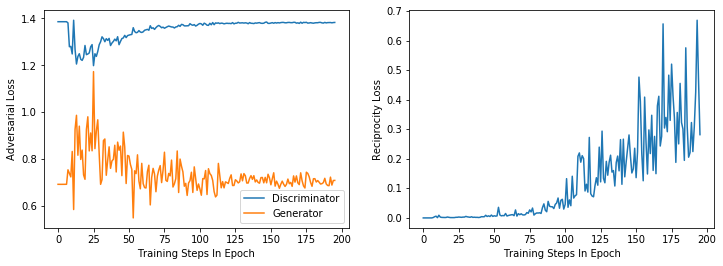

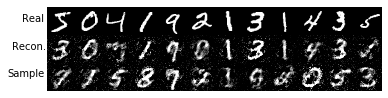

---------------------------------------------------------
Epoch: 50
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3834 - Loss_G: 0.7037 - Loss_R: 0.3462 

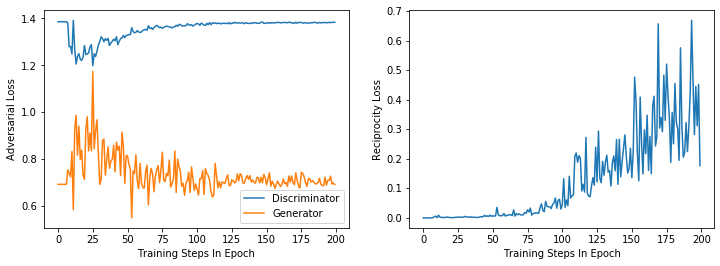

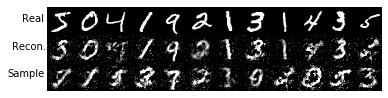

---------------------------------------------------------
Epoch: 51
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3837 - Loss_G: 0.6986 - Loss_R: 0.2916 

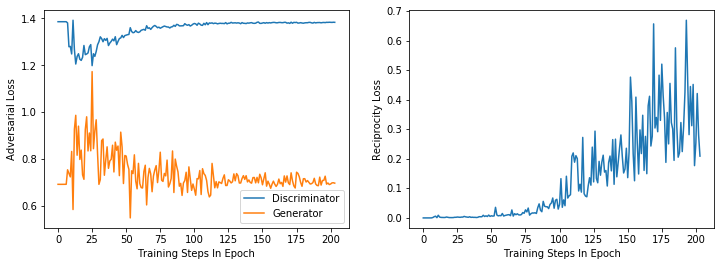

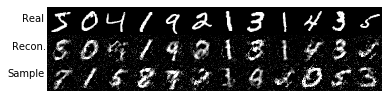

---------------------------------------------------------
Epoch: 52
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3840 - Loss_G: 0.7023 - Loss_R: 0.3695 

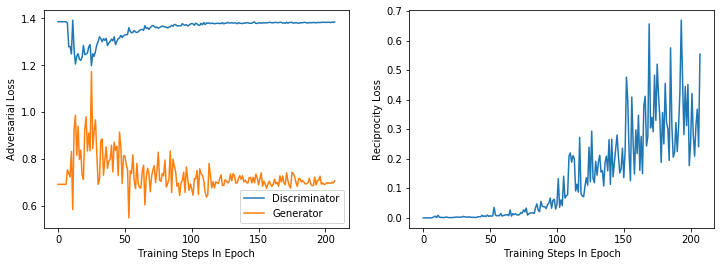

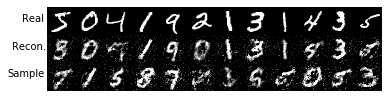

---------------------------------------------------------
Epoch: 53
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3836 - Loss_G: 0.7056 - Loss_R: 0.2904 

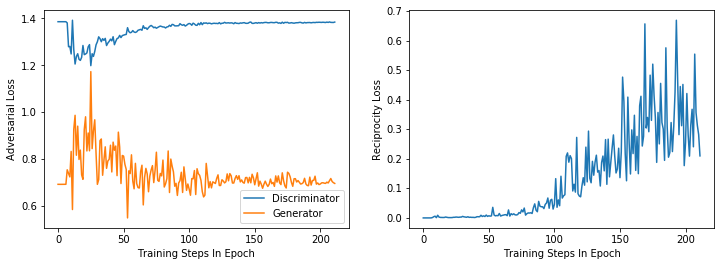

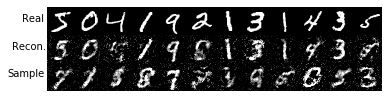

---------------------------------------------------------
Epoch: 54
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3834 - Loss_G: 0.7003 - Loss_R: 0.4394 

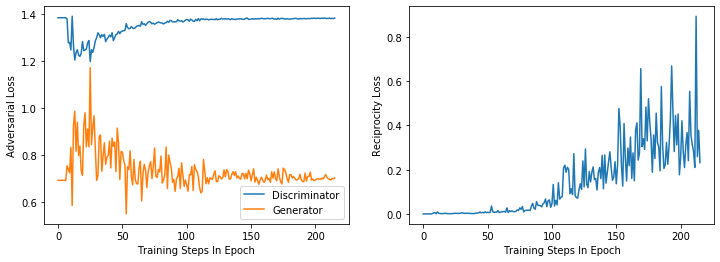

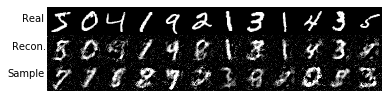

---------------------------------------------------------
Epoch: 55
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3835 - Loss_G: 0.7016 - Loss_R: 0.5014 

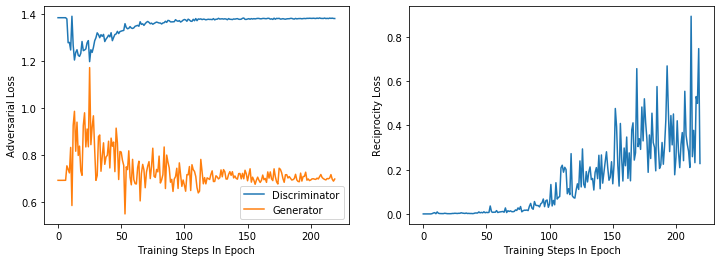

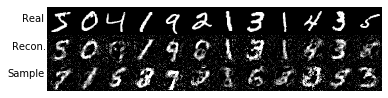

---------------------------------------------------------
Epoch: 56
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3837 - Loss_G: 0.6981 - Loss_R: 0.4582 

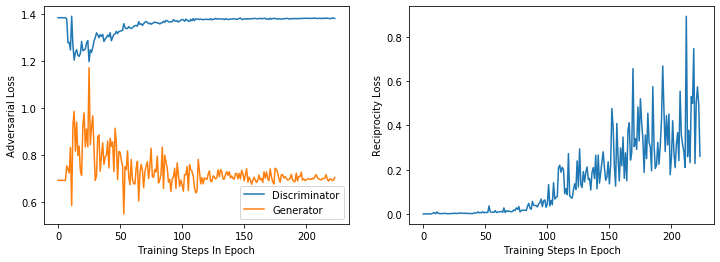

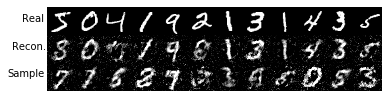

---------------------------------------------------------
Epoch: 57
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3823 - Loss_G: 0.7038 - Loss_R: 0.4536 

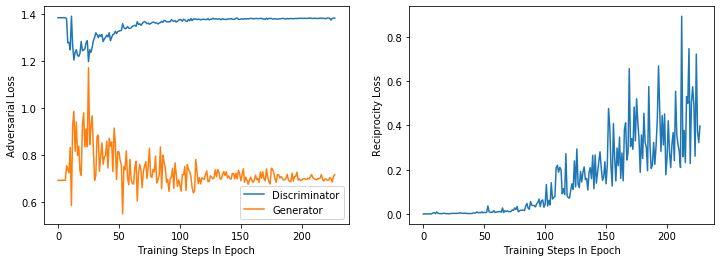

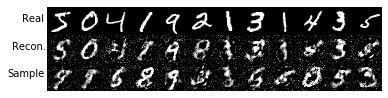

---------------------------------------------------------
Epoch: 58
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.4070 - Loss_G: 0.6973 - Loss_R: 2.1132 

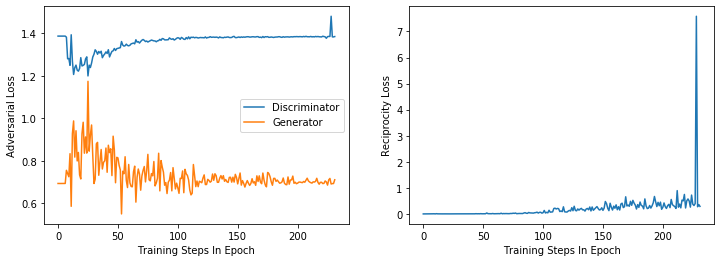

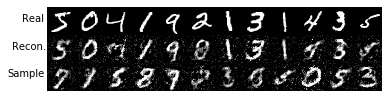

---------------------------------------------------------
Epoch: 59
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3839 - Loss_G: 0.7030 - Loss_R: 0.4720 

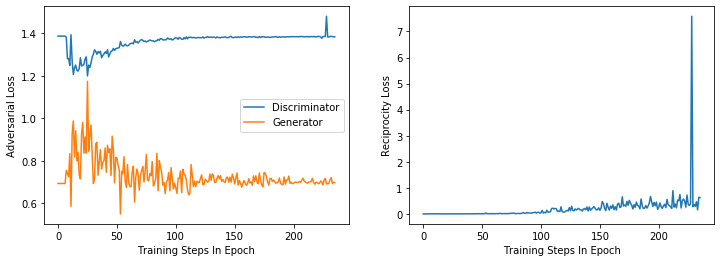

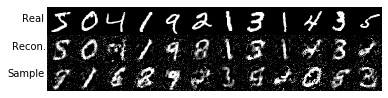

---------------------------------------------------------
Epoch: 60
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3834 - Loss_G: 0.6985 - Loss_R: 0.3226 

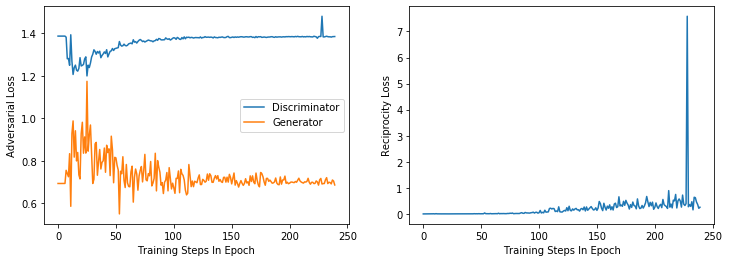

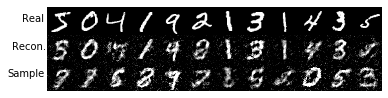

---------------------------------------------------------
Epoch: 61
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3839 - Loss_G: 0.7087 - Loss_R: 0.3794 

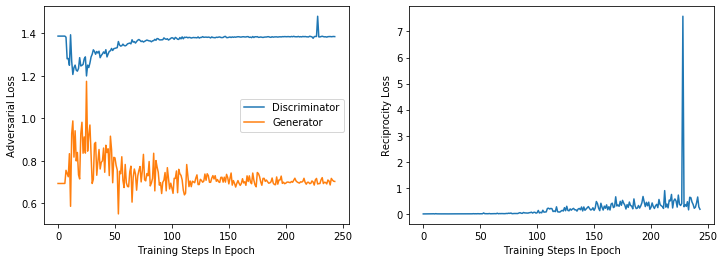

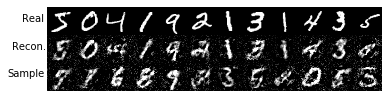

---------------------------------------------------------
Epoch: 62
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3826 - Loss_G: 0.7011 - Loss_R: 0.3151 

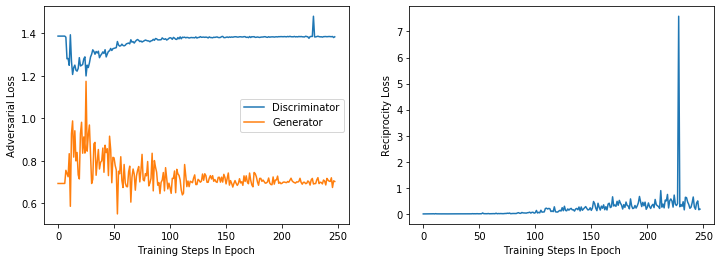

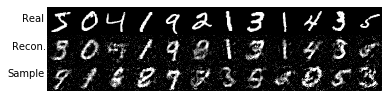

---------------------------------------------------------
Epoch: 63
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3827 - Loss_G: 0.7074 - Loss_R: 0.4325 

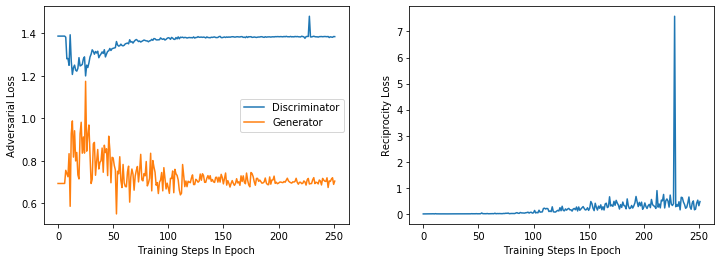

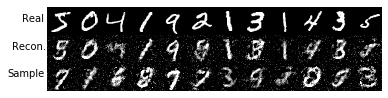

---------------------------------------------------------
Epoch: 64
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3827 - Loss_G: 0.7046 - Loss_R: 0.3884 

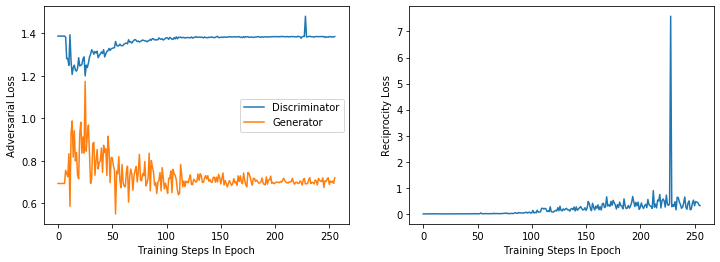

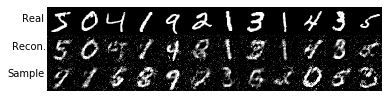

---------------------------------------------------------
Epoch: 65
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3839 - Loss_G: 0.7027 - Loss_R: 0.6028 

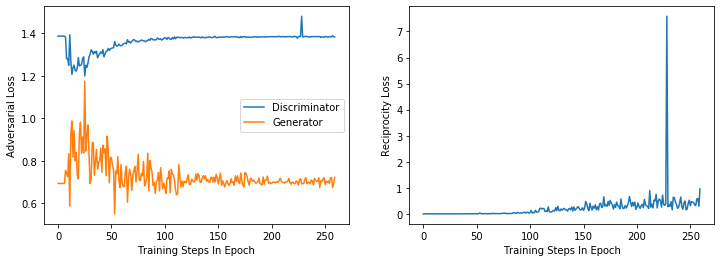

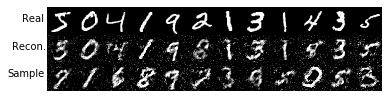

---------------------------------------------------------
Epoch: 66
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3830 - Loss_G: 0.7163 - Loss_R: 0.6105 

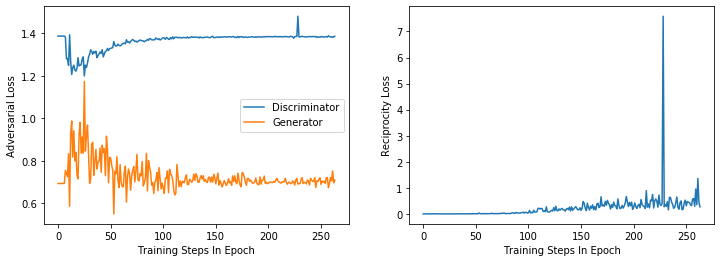

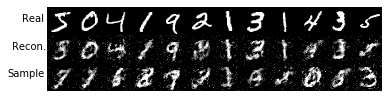

---------------------------------------------------------
Epoch: 67
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3830 - Loss_G: 0.7125 - Loss_R: 0.7250 

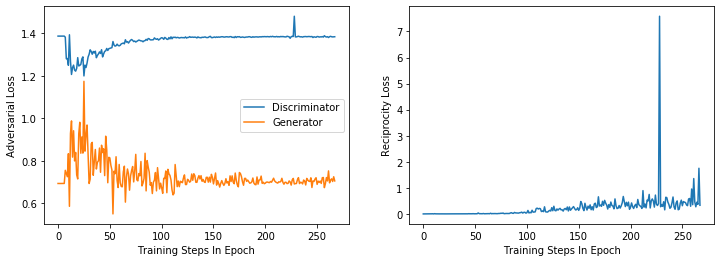

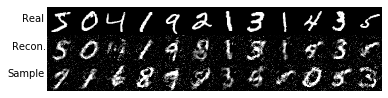

---------------------------------------------------------
Epoch: 68
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3826 - Loss_G: 0.7031 - Loss_R: 0.3237 

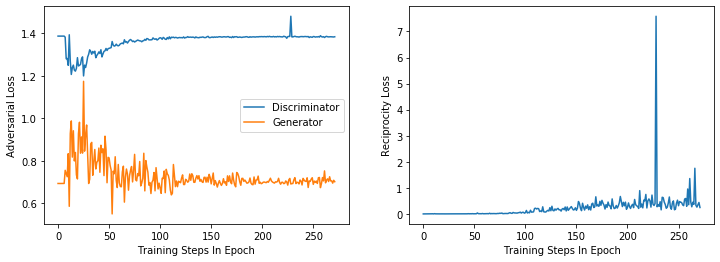

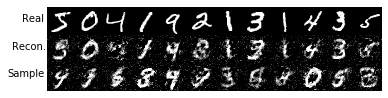

---------------------------------------------------------
Epoch: 69
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3833 - Loss_G: 0.7151 - Loss_R: 0.4721 

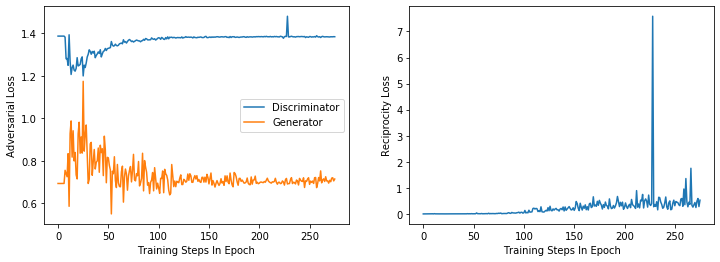

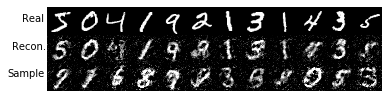

---------------------------------------------------------
Epoch: 70
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3823 - Loss_G: 0.6982 - Loss_R: 0.4259 

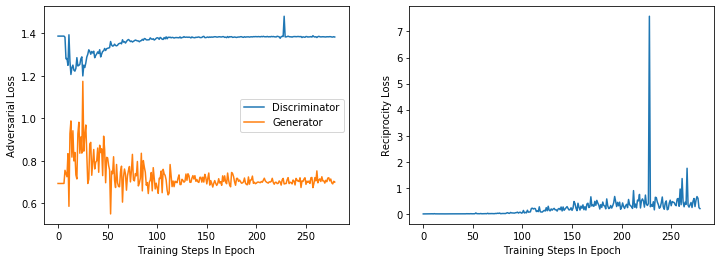

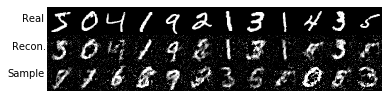

---------------------------------------------------------
Epoch: 71
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3784 - Loss_G: 0.7146 - Loss_R: 0.4656 

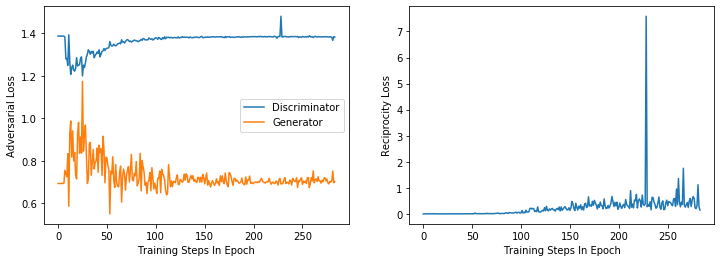

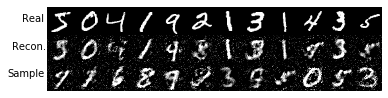

---------------------------------------------------------
Epoch: 72
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3818 - Loss_G: 0.7042 - Loss_R: 0.5803 

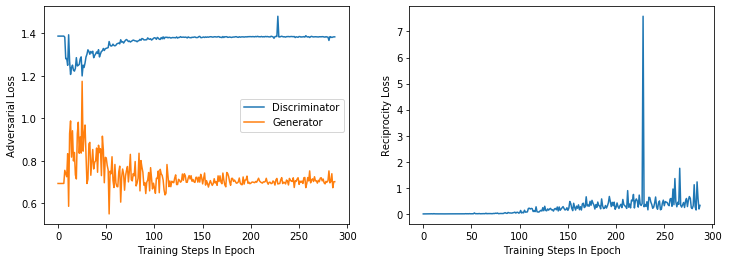

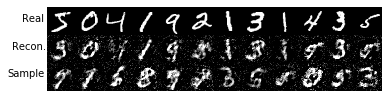

---------------------------------------------------------
Epoch: 73
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3827 - Loss_G: 0.7033 - Loss_R: 0.4505 

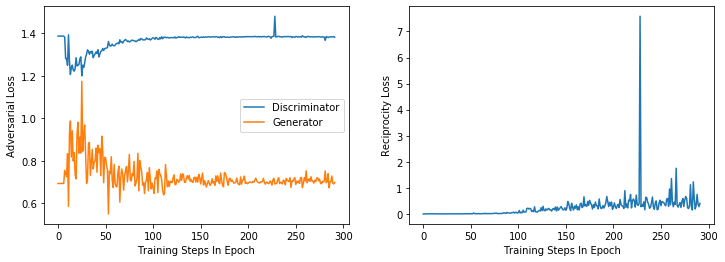

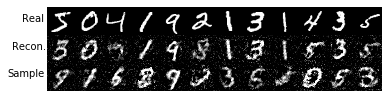

---------------------------------------------------------
Epoch: 74
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3824 - Loss_G: 0.7080 - Loss_R: 0.5416 

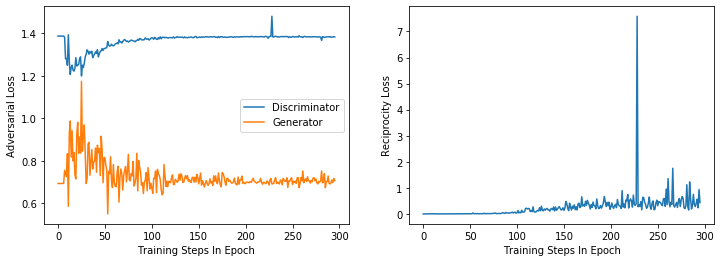

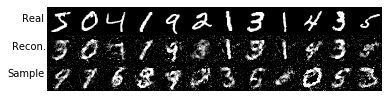

---------------------------------------------------------
Epoch: 75
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3808 - Loss_G: 0.7078 - Loss_R: 0.5781 

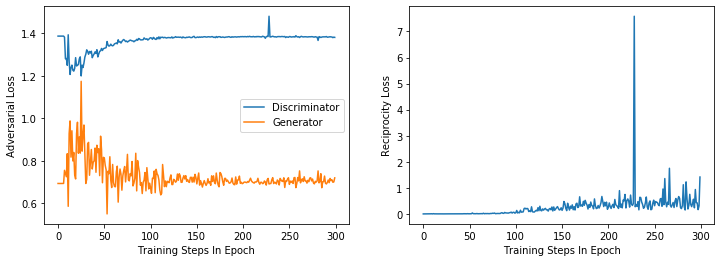

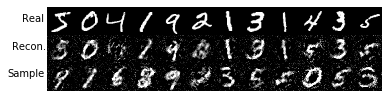

---------------------------------------------------------
Epoch: 76
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3819 - Loss_G: 0.7059 - Loss_R: 0.4154 

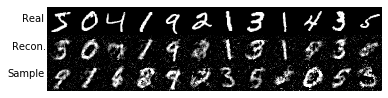

---------------------------------------------------------
Epoch: 77
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3820 - Loss_G: 0.7038 - Loss_R: 0.3997 

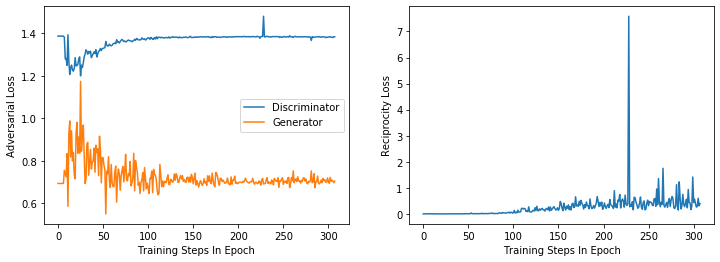

---------------------------------------------------------
Epoch: 78
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3824 - Loss_G: 0.7041 - Loss_R: 0.5136 

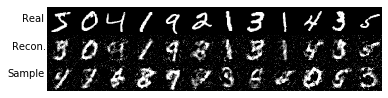

---------------------------------------------------------
Epoch: 79
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3836 - Loss_G: 0.7029 - Loss_R: 0.4175 

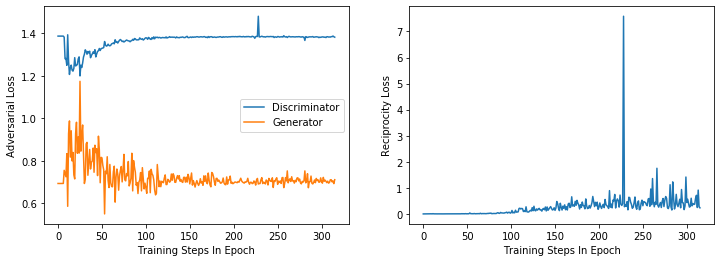

---------------------------------------------------------
Epoch: 80
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3821 - Loss_G: 0.7081 - Loss_R: 0.4182 

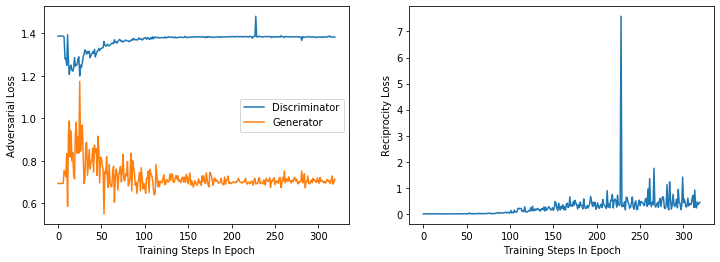

---------------------------------------------------------
Epoch: 81
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3808 - Loss_G: 0.7066 - Loss_R: 0.8006 

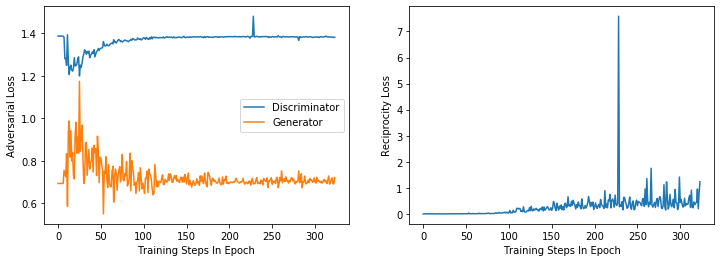

---------------------------------------------------------
Epoch: 82
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3822 - Loss_G: 0.7110 - Loss_R: 0.4600 

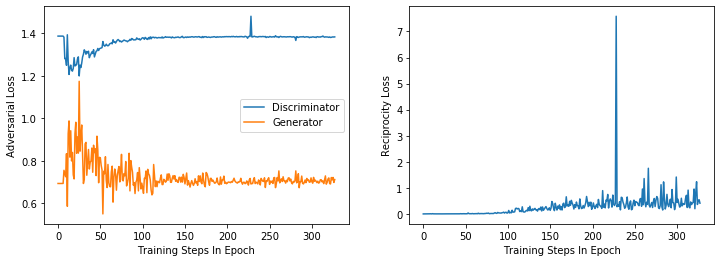

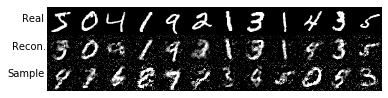

---------------------------------------------------------
Epoch: 83
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3821 - Loss_G: 0.7048 - Loss_R: 0.3909 

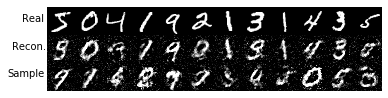

---------------------------------------------------------
Epoch: 84
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3817 - Loss_G: 0.7021 - Loss_R: 0.4002 

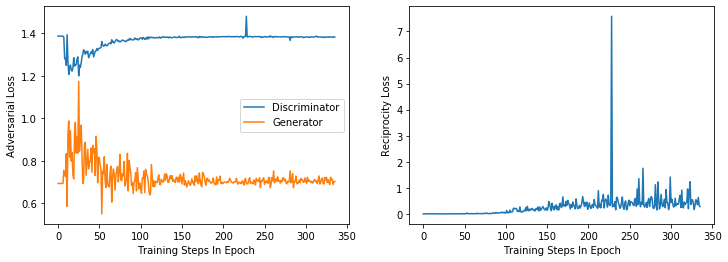

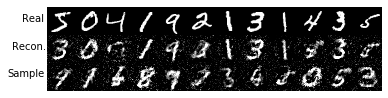

---------------------------------------------------------
Epoch: 85
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3816 - Loss_G: 0.7039 - Loss_R: 0.3926 

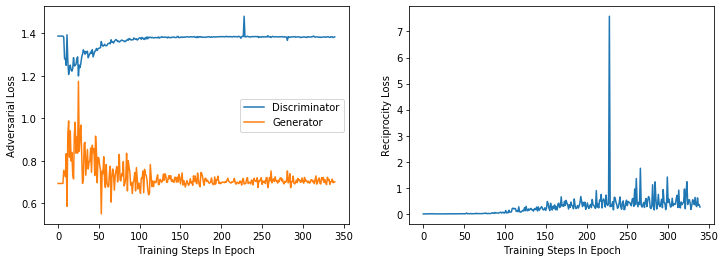

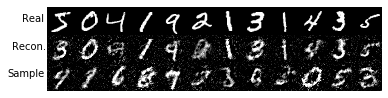

---------------------------------------------------------
Epoch: 86
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3839 - Loss_G: 0.7032 - Loss_R: 0.4611 

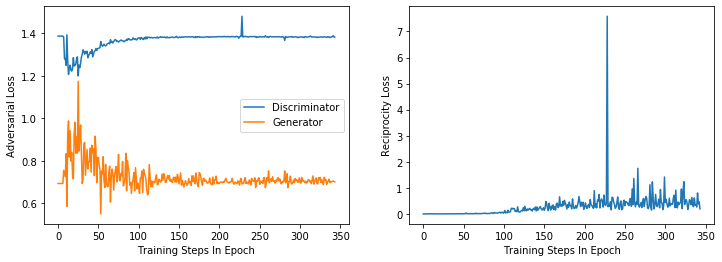

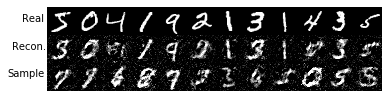

---------------------------------------------------------
Epoch: 87
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3815 - Loss_G: 0.7054 - Loss_R: 0.6333 

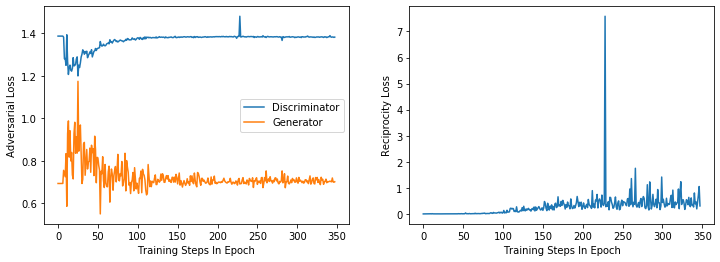

---------------------------------------------------------
Epoch: 88
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3812 - Loss_G: 0.7086 - Loss_R: 0.7718 

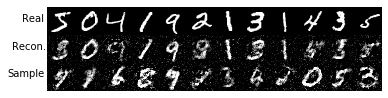

---------------------------------------------------------
Epoch: 89
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3824 - Loss_G: 0.7018 - Loss_R: 0.3405 

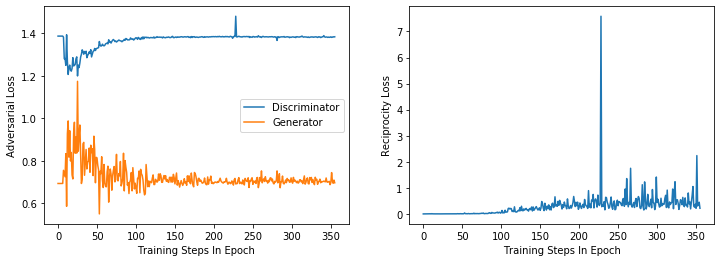

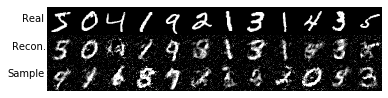

---------------------------------------------------------
Epoch: 90
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3820 - Loss_G: 0.7150 - Loss_R: 0.5589 

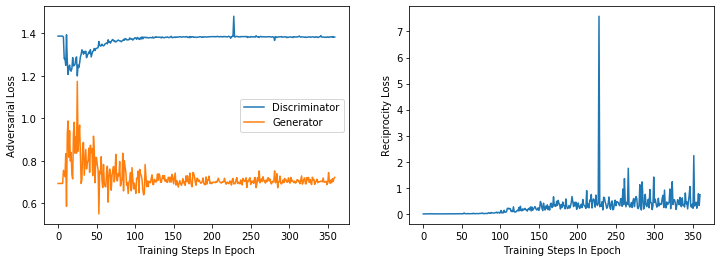

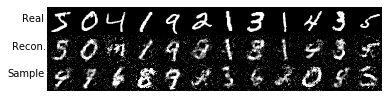

---------------------------------------------------------
Epoch: 91
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3816 - Loss_G: 0.7082 - Loss_R: 0.8141 

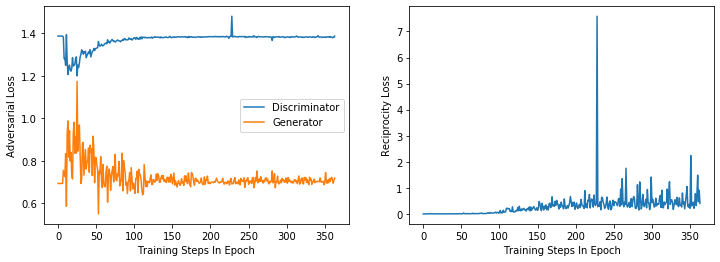

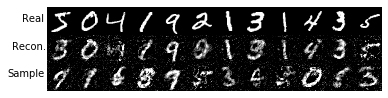

---------------------------------------------------------
Epoch: 92
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3821 - Loss_G: 0.7061 - Loss_R: 0.4677 

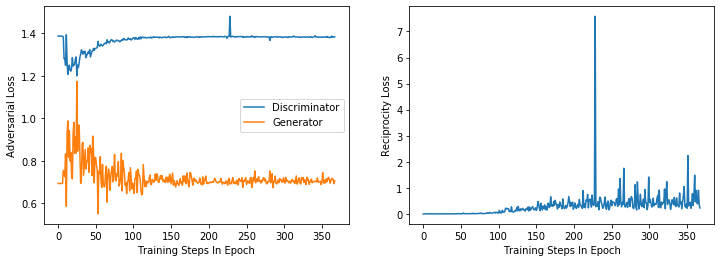

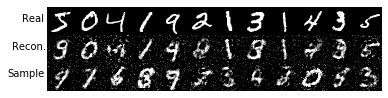

---------------------------------------------------------
Epoch: 93
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3828 - Loss_G: 0.7029 - Loss_R: 0.5523 

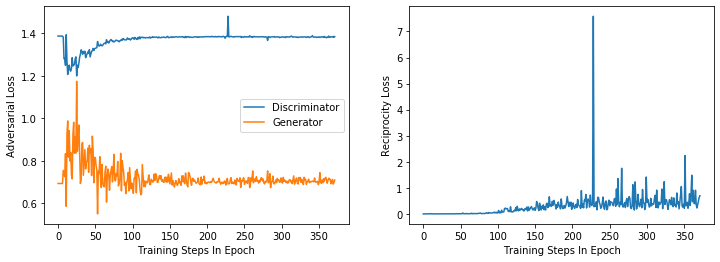

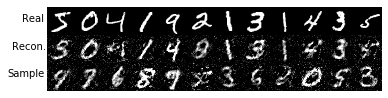

---------------------------------------------------------
Epoch: 94
399/468 [========================>.....] - ETA: 5s - Loss_D: 1.3833 - Loss_G: 0.6939 - Loss_R: 0.3996 

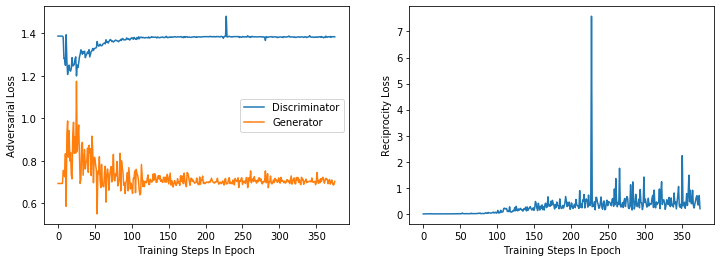

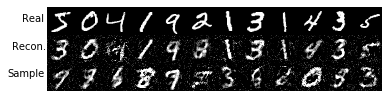

---------------------------------------------------------
Epoch: 95
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3822 - Loss_G: 0.7065 - Loss_R: 0.3968 

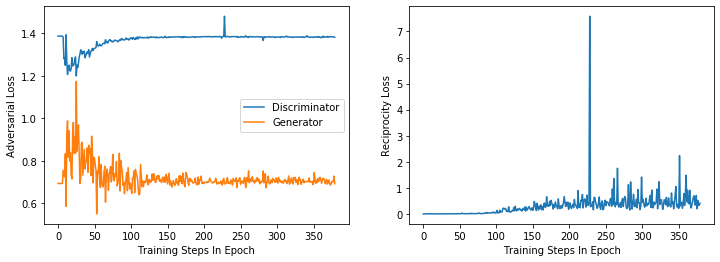

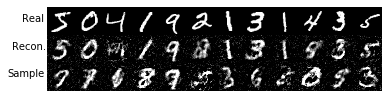

---------------------------------------------------------
Epoch: 96
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3819 - Loss_G: 0.7043 - Loss_R: 0.4470 

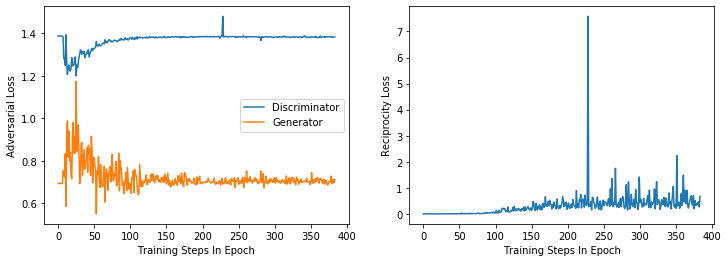

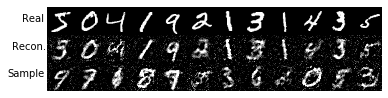

---------------------------------------------------------
Epoch: 97
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3827 - Loss_G: 0.7061 - Loss_R: 0.5712 

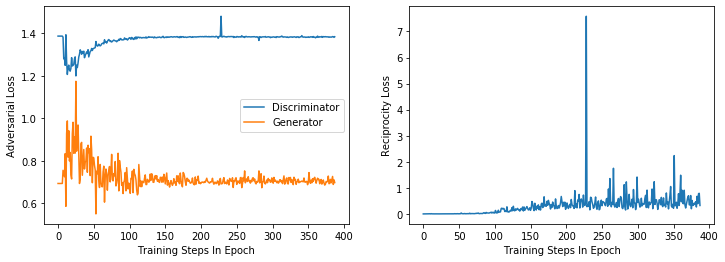

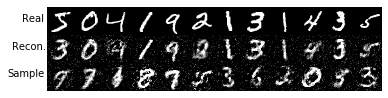

---------------------------------------------------------
Epoch: 98
399/468 [========================>.....] - ETA: 4s - Loss_D: 1.3824 - Loss_G: 0.6973 - Loss_R: 0.2493 

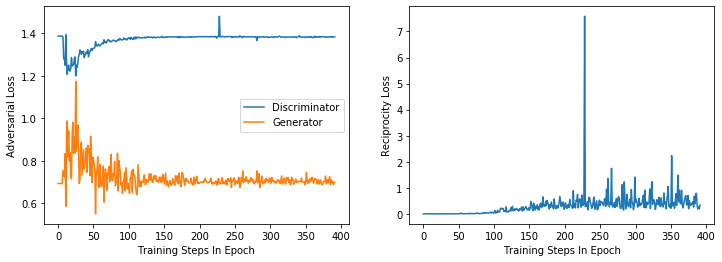

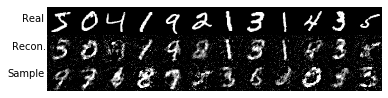

---------------------------------------------------------
Epoch: 99
399/468 [========================>.....] - ETA: 5s - Loss_D: 1.3829 - Loss_G: 0.7095 - Loss_R: 0.4311 

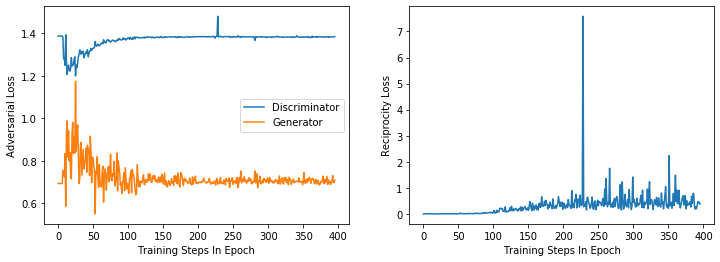

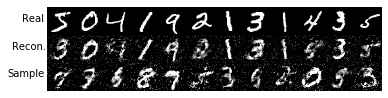

---------------------------------------------------------
Epoch: 100
399/468 [========================>.....] - ETA: 5s - Loss_D: 1.3830 - Loss_G: 0.7064 - Loss_R: 0.4521 

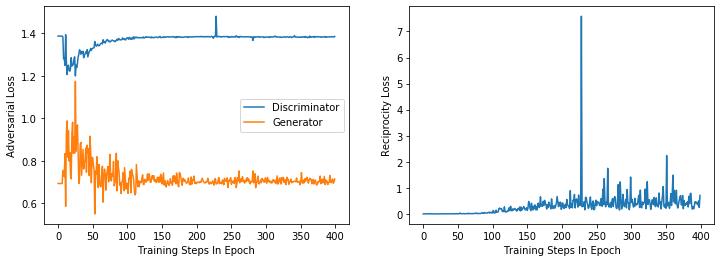

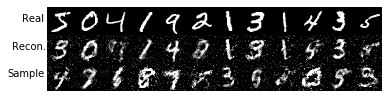

---------------------------------------------------------


In [21]:
epochs = 100
steps_per_epoch = 60000 // BATCH_SIZE

losses = {  "Loss_D" : [],
            "Loss_G" : [],
            "Loss_R" : [],
         }

for epoch in range(0, epochs):
    
    print("Epoch:", epoch+1)
    
    # Create progress bar for current epoch
    progress = Progbar(steps_per_epoch, width=30, verbose=1, interval=1)

    for i in range(steps_per_epoch):

        # -------------------------------#
        # Step I - Update Discriminator  #
        # -------------------------------#
        
        # Random mini-batch from dataset
        x_real = get_batch(i)
        # samples from prior N(0, 1)
        z = np.random.normal(0, 1, (BATCH_SIZE, Z_DIM))
        # generate fake images
        x_fake = generator.predict(z)
        
        # Compute loss and apply gradients
        with tf.GradientTape() as tape:
            
            fake_pred = discriminator(x_fake)
            
            real_pred = discriminator(x_real)
            
            loss_d = K.mean(f(-real_pred) + f(fake_pred))
        
            # Add the R1 term here
            x_real = tf.Variable(x_real, dtype=tf.float32)
            with tf.GradientTape() as r1_tape:
                r1_tape.watch(x_real)
                # 1. Get the discriminator output for real images
                pred = discriminator(x_real)

            # 2. Calculate the gradients w.r.t to the real images.
            grads = r1_tape.gradient(pred, [x_real])[0]

            # 3. Calcuate the squared norm of the gradients
            r1_penalty = tf.reduce_sum(tf.square(grads))
            loss_d += γ/2 * r1_penalty
            
            
        gradients = tape.gradient(loss_d, θ_E+θ_D)
        Adam_D.apply_gradients(zip(gradients, θ_E+θ_D))
        
        

        # ----------------------------#
        #  Step II - Update Generator #
        # ----------------------------#
        
        # samples from prior N(0, 1)
        z = np.random.normal(0, 1, (BATCH_SIZE, Z_DIM))
        # Compute loss and apply gradients
        with tf.GradientTape() as tape:

            fake_pred = discriminator(generator(z))

            loss_g = K.mean(f(-fake_pred))

        gradients = tape.gradient(loss_g, θ_F+θ_G)
        Adam_G.apply_gradients(zip(gradients, θ_F+θ_G))
        

        # ------------------------------#
        #  Step III - Update Reciprocal #
        # ------------------------------#
        
        # samples from prior N(0, 1)
        z = np.random.normal(0, 1, (BATCH_SIZE, Z_DIM))
        # Get w
        w = F(z)
        # Compute loss and apply gradients
        with tf.GradientTape() as tape:
            
            w_pred = reciprocal(w)
            
            loss_r = l2(w, w_pred)
            
        gradients = tape.gradient(loss_r, θ_G+θ_E)
        Adam_R.apply_gradients(zip(gradients, θ_G+θ_E))
        
        
        if i % 100 == 99:
            
            loss_d = loss_d.numpy()
            loss_g = loss_g.numpy()
            loss_r = loss_r.numpy()
            
            # Progress
            progress.update(i, values=[ ("Loss_D", loss_d),
                                        ("Loss_G", loss_g),
                                        ("Loss_R", loss_r),
                                      ])

            # Save losses each step
            losses["Loss_D"].append(loss_d)
            losses["Loss_G"].append(loss_g)
            losses["Loss_R"].append(loss_r)
    
    # ---------------#
    #  END OF EPOCH  #
    # ---------------#
    
    # LOSSES
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(range(len(losses["Loss_D"])), losses["Loss_D"], label="Discriminator")
    ax[0].plot(range(len(losses["Loss_G"])), losses["Loss_G"], label="Generator")
    ax[0].set_xlabel("Training Steps In Epoch")
    ax[0].set_ylabel("Adversarial Loss")
    ax[0].legend()

    ax[1].plot(range(len(losses["Loss_R"])), losses["Loss_R"])
    ax[1].set_xlabel("Training Steps In Epoch")
    ax[1].set_ylabel("Reciprocity Loss")
    plt.show()
    
    # IMAGES
    
    # Get random samples
    x_sample = generator.predict(z_test)
    x_sample = x_sample.reshape(12, 28, 28)
    x_sample = [img for img in x_sample]
    x_sample = np.hstack(x_sample)

    # Get reconstructions
    x_recon = inference.predict(x_test)
    x_recon = x_recon.reshape(12, 28, 28)
    x_recon = [img for img in x_recon]
    x_recon = np.hstack(x_recon)

    # Create canvas
    canvas = np.vstack([x_reals, x_recon, x_sample])
    canvas = np.clip(canvas, 0, 1)

    # Show
    plt.imshow(canvas, cmap="gray")
    plt.text(-25, 14, s="Real")
    plt.text(-35, 14*3, s="Recon.")
    plt.text(-40, 14*5, s="Sample")
    plt.axis("off")
    
    #plt.savefig("./img_out/progress_{0:03d}.png".format(epoch), dpi=100)
    plt.show()

    # Shuffle Data
    #np.random.shuffle(indices)
    
    print("---------------------------------------------------------")

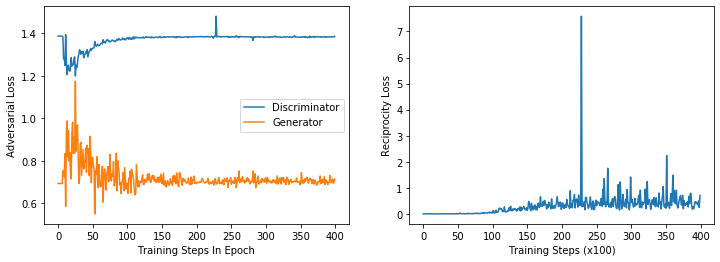

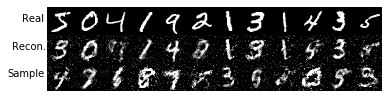

In [22]:
# LOSSES
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(range(len(losses["Loss_D"])), losses["Loss_D"], label="Discriminator")
ax[0].plot(range(len(losses["Loss_G"])), losses["Loss_G"], label="Generator")
ax[0].set_xlabel("Training Steps In Epoch")
ax[0].set_ylabel("Adversarial Loss")
ax[0].legend()

ax[1].plot(range(len(losses["Loss_R"])), losses["Loss_R"])
ax[1].set_xlabel("Training Steps (x100)")
ax[1].set_ylabel("Reciprocity Loss")

plt.savefig("./TF2_MNIST_traing_curve_100_epochs.png", dpi=100)

plt.show()

# IMAGES

# Get random samples
x_sample = generator.predict(z_test)
x_sample = x_sample.reshape(12, 28, 28)
x_sample = [img for img in x_sample]
x_sample = np.hstack(x_sample)

# Get reconstructions
x_recon = inference.predict(x_test)
x_recon = x_recon.reshape(12, 28, 28)
x_recon = [img for img in x_recon]
x_recon = np.hstack(x_recon)

# Create canvas
canvas = np.vstack([x_reals, x_recon, x_sample])
canvas = np.clip(canvas, 0, 1)

# Show
plt.imshow(canvas, cmap="gray")
plt.text(-25, 14, s="Real")
plt.text(-35, 14*3, s="Recon.")
plt.text(-40, 14*5, s="Sample")
plt.axis("off")

plt.savefig("./TF2_MNIST_100_epochs.png.png".format(epoch), dpi=100)
plt.show()